# Movie Ratings Capstome

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
# import prepare_stephen as ps
# import prepare_nick as pn
import wrangle as w
import datetime

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import scipy.stats as stats
from math import sqrt
import Final.final_acquire as fa

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set default graph size
plt.rc('figure', figsize=(20.0, 10.0))
sns.set(rc = {'figure.figsize':(20,10)})


### Get Raw dirty data https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=links.csv

In [32]:
df = w.wrangle_df()

Using cached CSV


In [33]:
df.shape

(6893, 23)

In [34]:
df.head(1)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,runtime.1,imdb_id
id,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,False,3.49375,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,False,1995-12-09,1995,98.0,tt0113101


# Prepare Data

> ### Get prepared data
> - Handle missing values (Drop / fill by mean|mode)
> - Encode categorical data
> - Columns content split required:
    - cast
    - crew
    - production_companies
    - production_countries
> - Rename columns to ease readability
> - Drop duplicates & unnecessary columns
> - Convert release_date column from object data type to datetime format and index date
> - Data scaling
> - Feature engineering
> - Split the data into train, validate, test

### Streamlined Data

In [69]:
import Final.final_acquire as fa
# Acquire & wrangle data
df = fa.wrangle_df()
df.head(2)

Using cached CSV


,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,runtime.1,imdb_id
id,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,False,3.49375,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,False,1995-12-09,1995,98.0,tt0113101
6,Judgment Night,False,3.88382,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,False,1993-10-15,1993,110.0,tt0107286


#### Initial Data Check

### Final check for nulls 

In [70]:
train.isnull().any()

title                   False
success                 False
success_rating          False
genres                  False
cast_actor_1            False
cast_actor_2            False
cast_actor_3            False
total_n_cast            False
budget                  False
revenue                 False
profit_amount           False
vote_average            False
vote_count              False
production_companies    False
production_countries    False
overview                False
popularity              False
runtime                 False
profitable              False
release_date            False
release_year            False
runtime.1               False
imdb_id                 False
dtype: bool

In [71]:
# df['profit_amount'] = df.revenue - df.budget 

# df['month'] = pd.DatetimeIndex(df['release_date']).month

# df.head()

> ### Split the data

In [72]:

train, validate, test = fa.train_validate_test_split(df)
train.shape, validate.shape, test.shape

((3859, 23), (1655, 23), (1379, 23))

# Explore Data

> ### Use train set

> ### Visualizations

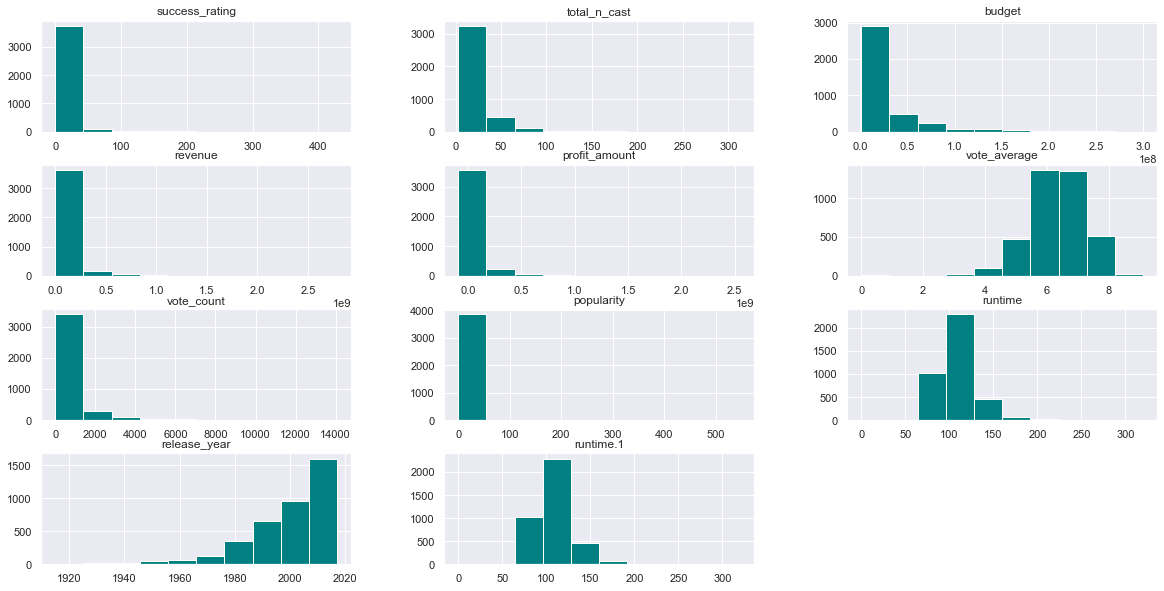

In [41]:
train.hist(color = 'teal')
plt.show()

### Correlation Heatmap

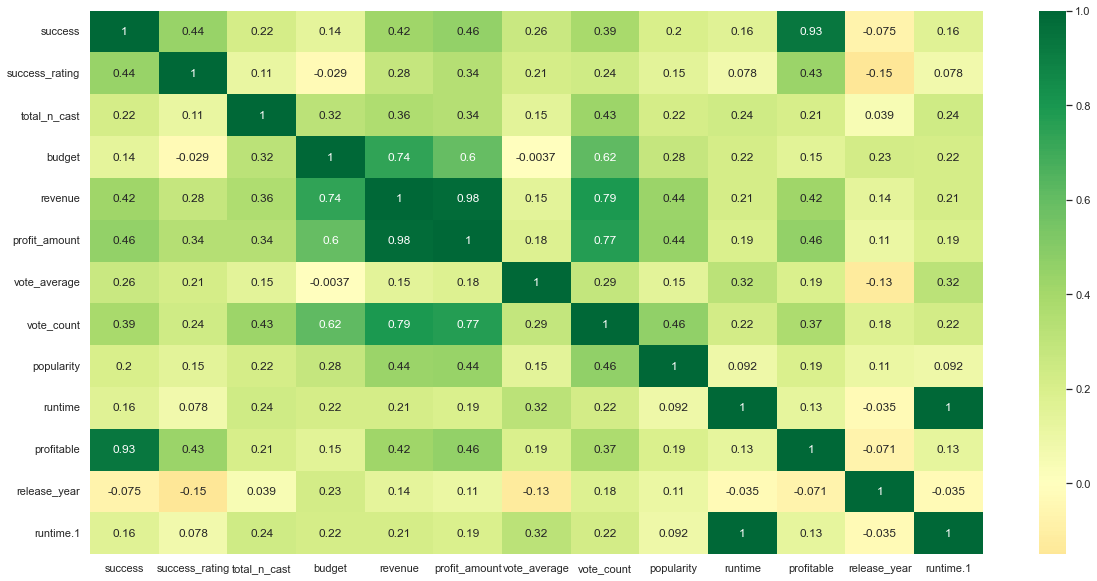

In [43]:
sns.heatmap(train.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
None

> ### Univariate Exploration

### Success vs Non-success Distribution

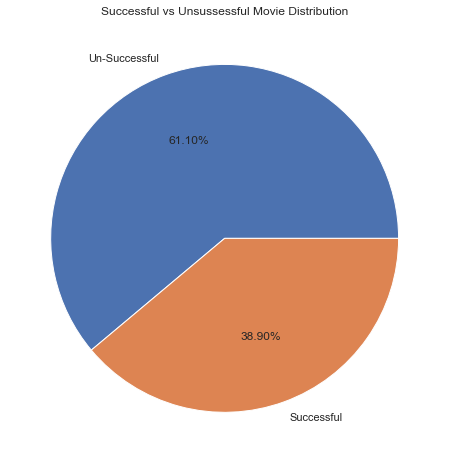

In [44]:
train1 = train.groupby(['success']).size()
labels = ['Un-Successful', 'Successful']

train1.plot(kind='pie', subplots = True, figsize=(8, 8), labels = labels, autopct='%1.2f%%')
plt.title("Successful vs Unsussessful Movie Distribution")
plt.ylabel("")
plt.show()

In [48]:
# after_1990 = df[df.release_year >= 1990]

# g = sns.catplot("success", col="month", col_wrap=4,
#                 data = after_1990,
#                 kind="count", height=3.5, aspect=.8, 
#                 palette='tab20')

# plt.show()

### Movie Success from 1990 - 2017

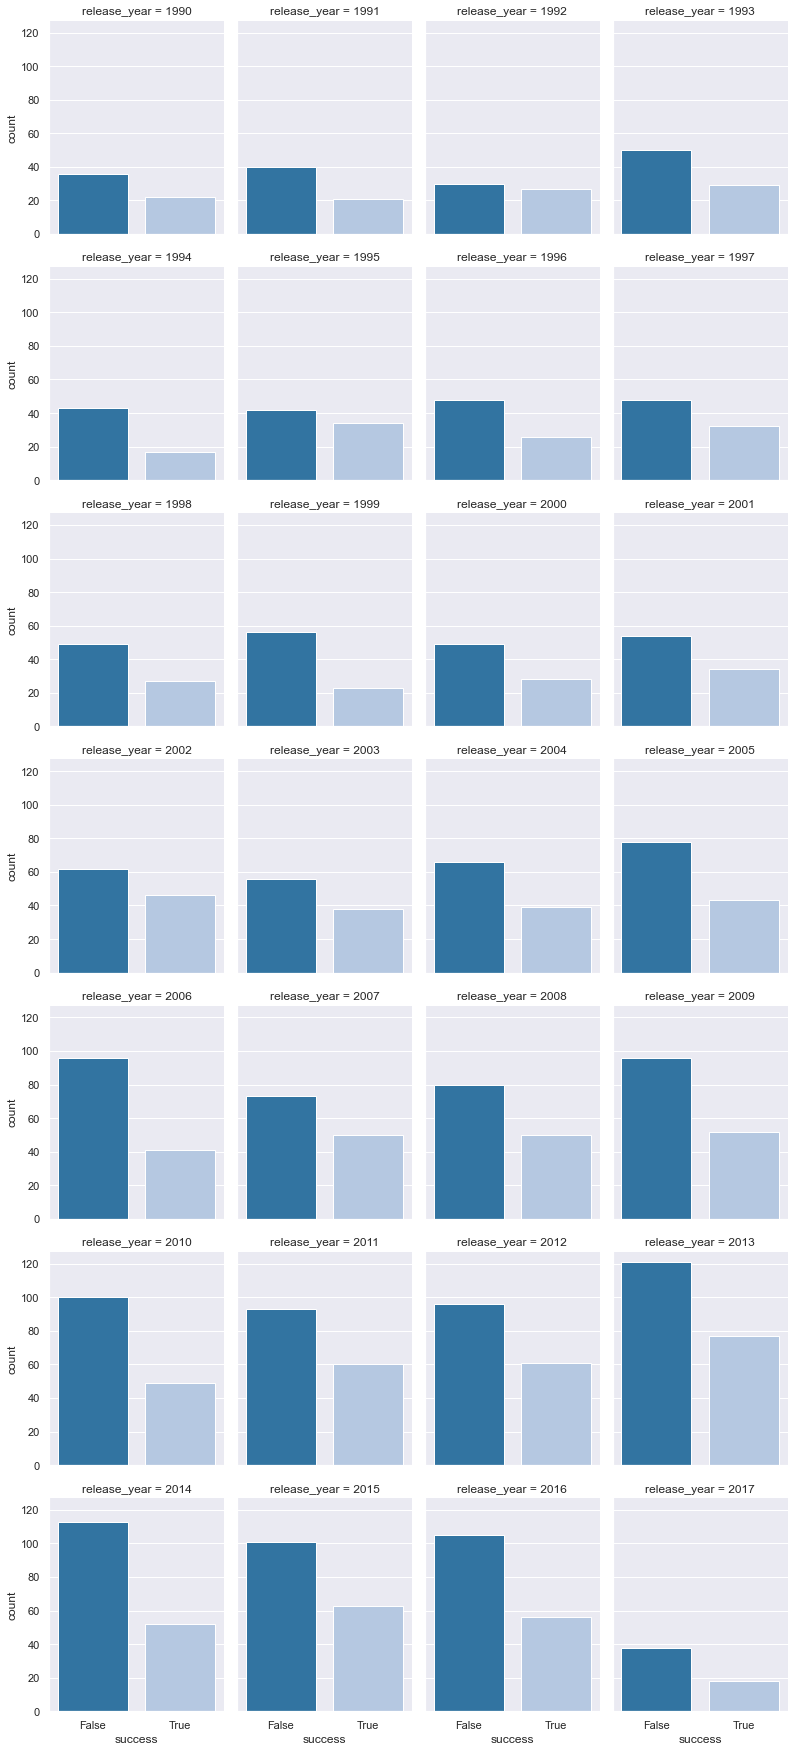

In [49]:
after_1990 = train[train.release_year >= 1990]

g = sns.catplot("success", col="release_year", col_wrap=4,
                data = after_1990,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')

plt.show()

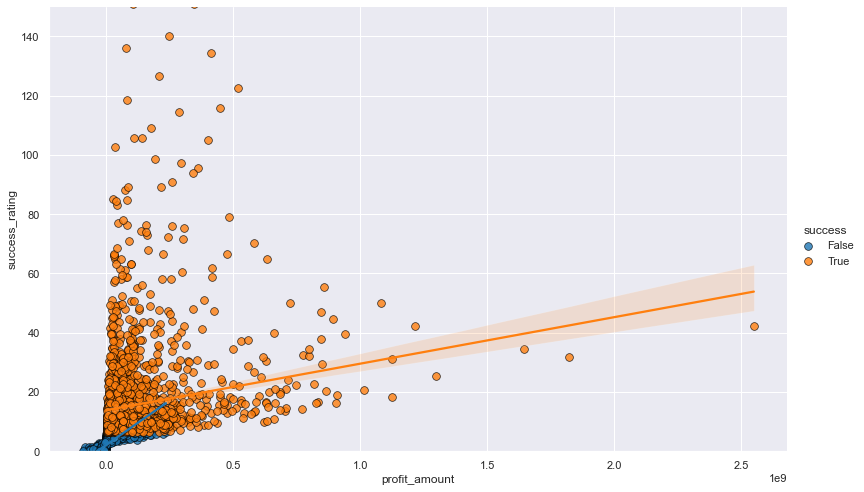

In [50]:
g = sns.lmplot(x="profit_amount", y="success_rating", hue="success", data=train, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))
g.set(ylim=(0, 150))
None

> ### Bi-Variate Exploration

> ### Multi-Variate Exploration

> ### Hypothesis testing

In [51]:
# Set alpha value

alpha = 0.05

####  (1). Is there a relationship between budget and revenue? 
 

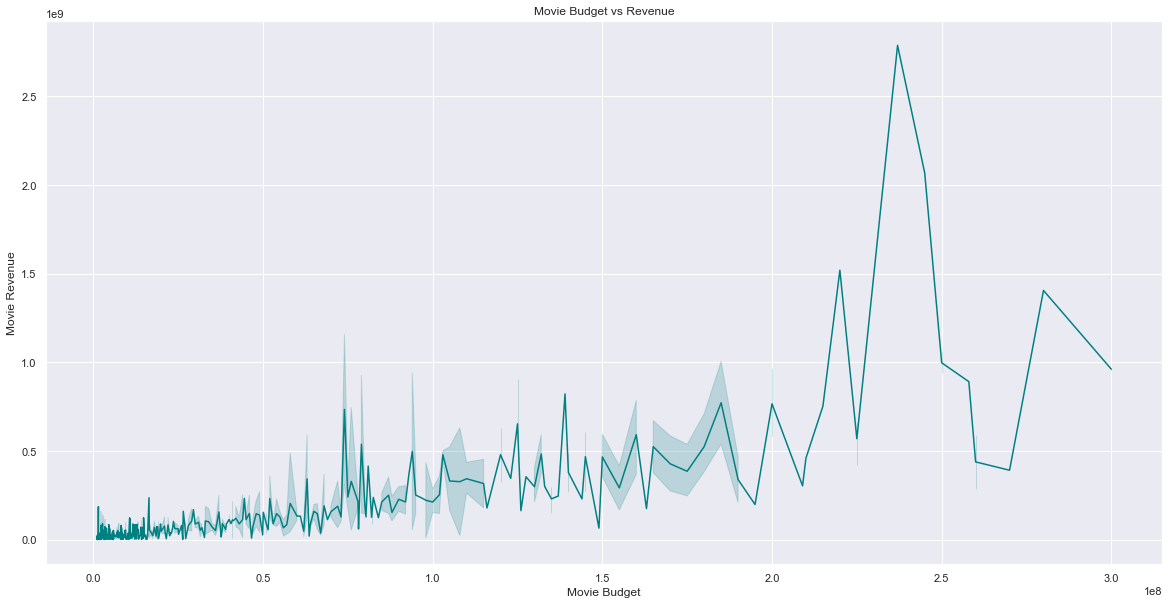

In [52]:
ax = sns.lineplot(x = train.budget, y = df.revenue, color = 'teal')
ax.set(xlabel = 'Movie Budget', ylabel = 'Movie Revenue')
ax.set(title = 'Movie Budget vs Revenue')
None

In [53]:
revenue = train.revenue.mean()
budget = train.budget.mean()

print(f'Mean Revenue: {revenue} \nMean Budget {budget}')
print('---------------------------------')
print(f'Mean Profit Difference {revenue - budget}')
print('---------------------------------')

Mean Revenue: 74923985.8235294 
Mean Budget 27608571.924073596
---------------------------------
Mean Profit Difference 47315413.899455816
---------------------------------


In [54]:
H0 = 'The is correlation between revenue and budgeting'
H1 = 'The is no correlation between revenue and budgeting'

x = train.budget
y = train.revenue

corr, p = stats.pearsonr(x, y)
corr, p

(0.7365723596434843, 0.0)

In [55]:
if (p < alpha):
    print(f'Reject --> {H0}')
else:
    print(f'Failed to Reject {H0}')

Reject --> The is correlation between revenue and budgeting


> NO CORRELATION BETWEEN REVENUE & BUDGET

#### (2). How runtime affect movie success?



In [57]:
train.success_rating.head()

id
90        71.708375
504       26.415630
19931     10.605185
116741     2.313793
8080       1.324074
Name: success_rating, dtype: float64

In [24]:
# sns.relplot(x = 'runtime', y = 'budget', data = df, kind = 'line',  ci="sd");
# None

#### (3). What are the top 5 highest voted movies?


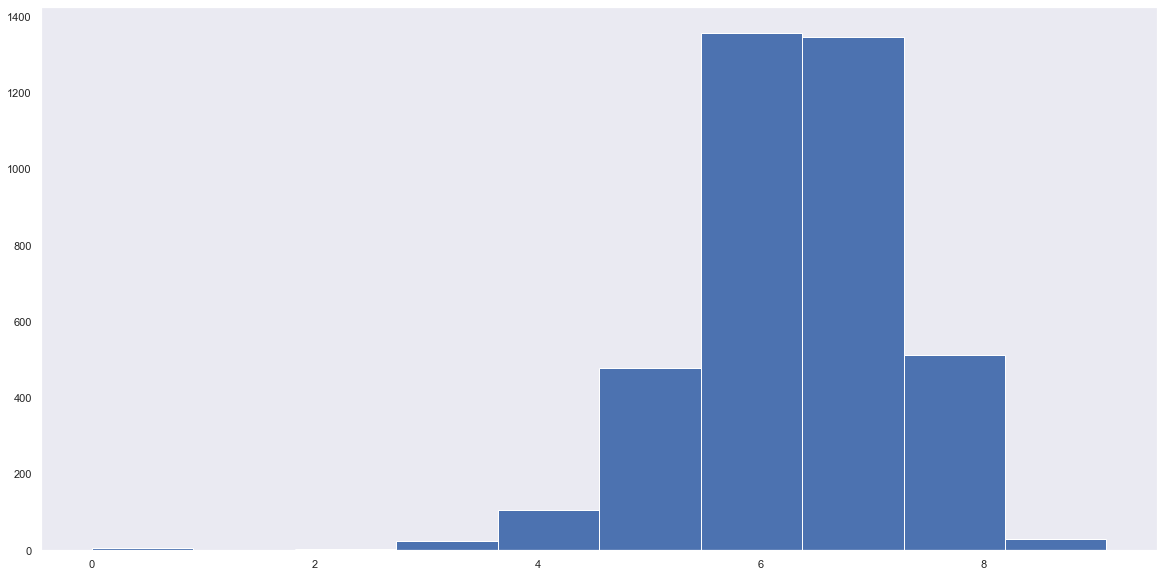

In [58]:
train.vote_average.hist(grid = False)
None

In [59]:
top_5 = train.vote_average.nlargest(n = 5)
top_5

id
19404     9.1
24128     8.7
38794     8.6
251053    8.5
278       8.5
Name: vote_average, dtype: float64

#### (4). What are top 5 Highest profit movies?

#### (5). Which genre has the highest profit? Or top 5?


In [61]:
top_5_most_profitable = train.nlargest(n = 5, columns = ['profit_amount'])
top_5_most_profitable.head(1)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,runtime.1,imdb_id
id,,,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,True,42.348837,Action Adventure Fantasy Science Fiction,Sam Worthington,Zoe Saldana,Sigourney Weaver,83.0,237000000.0,2.787965e+09,2.550965e+09,7.2,12114.0,IngeniousFilmPartners TwentiethCenturyFoxFilmC...,UnitedStatesofAmerica UnitedKingdom,"In the 22nd century, a paraplegic Marine is di...",185.070892,162.0,True,2009-12-10,2009,162.0,tt0499549


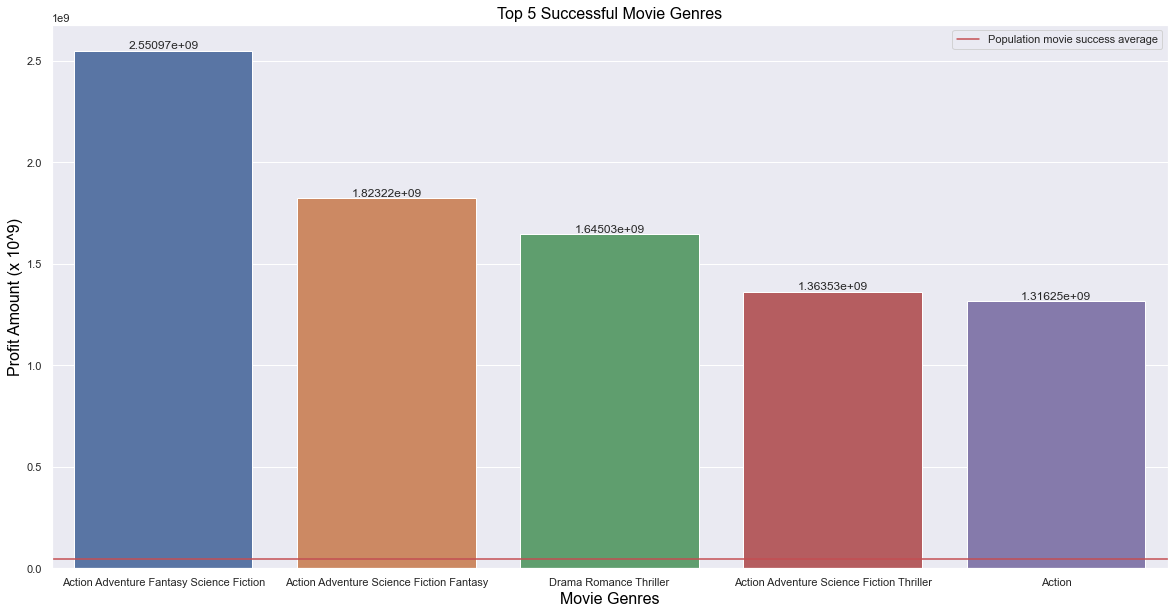

In [34]:
plt.title('Top 5 Successful Movie Genres', c = 'black', size = 16)
ax = sns.barplot(x = 'genres',  y = 'profit_amount', data = top_5_most_profitable)
ax.bar_label(ax.containers[0])  
overall_movie_profit_mean = df.profit_amount.mean()
plt.axhline(overall_movie_profit_mean, label="Population movie success average", color = 'r')
plt.ylabel('Profit Amount (x 10^9)', c = 'black', size = 16)
plt.xlabel('Movie Genres', c = 'black', size = 16)
plt.legend()
plt.show()

## [**NOTE: Genres appear as units***]



## - Avator has the highest profit 
####    - (1). Avator
####    - (2). Star Wars: The Force Awakens
####    - (3). Titanic
####    - (4). Jurassic World
####    - (5). Furious 7
    

### T-Test (One sample test)

In [62]:
H0 = 'Mean profit for top 5 successful movies = mean profit for all movies'
H1 = 'Mean profit for top 5 successful movies != mean profit for all movies'

overall_movie_profit_mean = train.profit_amount.mean()
top_5_movies_profit = top_5_most_profitable.profit_amount

t, p = stats.ttest_1samp(top_5_movies_profit, overall_movie_profit_mean)
t, p

(6.965353534265319, 0.0022332604275263554)

In [63]:
if (p/2 < alpha):
    print(f'Reject --> {H0}')
elif t < 0:
    print(f'Failed to Reject {H0}')
else:
    print(f'Failed to Reject {H0}')

Reject --> Mean profit for top 5 successful movies = mean profit for all movies


#### Q5 CONCLUSION -- Top five mean profit NOT EQUAL to overal mean
#### - Top five profit accounts to 2.72% of overall profit

In [64]:
overall_movie_profit_mean = train.profit_amount.sum()

top_5_movies_profit = top_5_most_profitable.profit_amount.sum()

(top_5_movies_profit/overall_movie_profit_mean) * 100

4.674830105527747

#### (6). How does a production company affect revenue? (Top 5 companies)

In [65]:
train['revenue'].nlargest(5)

id
19995     2.787965e+09
140607    2.068224e+09
597       1.845034e+09
24428     1.519558e+09
99861     1.405404e+09
Name: revenue, dtype: float64

In [66]:
# Most profitable production companies

top_5_production_companies = train.groupby(["production_companies"])\
.sum().sort_values("revenue", ascending=True).head(5)


top_5_production_companies

,success,success_rating,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,popularity,runtime,profitable,release_year,runtime.1
production_companies,,,,,,,,,,,,,
ProvidenceEntertainment TricorEntertainment TruthSoulArmor,0,2.950000e-07,20.0,10000000.0,1.0,-9999999.0,5.9,5.0,0.266895,93.0,0,2001,93.0
FreestyleReleasing BigScreenProductions CinemaWestFilms,0,2.800000e-07,9.0,10000000.0,1.0,-9999999.0,5.6,10.0,2.240259,114.0,0,2015,114.0
PeopleTreeFilms,0,6.400000e-07,6.0,10000000.0,2.0,-9999998.0,6.4,18.0,1.280455,132.0,0,2003,132.0
Gaumont LGMProductions,0,5.400000e-07,15.0,10000000.0,2.0,-9999998.0,5.4,30.0,3.668405,90.0,0,2006,90.0
AmericanFilmworks CecchiGoriPictures PentaEntertainment BuddingGrove,0,9.400000e-07,16.0,10000000.0,4.0,-9999996.0,4.7,11.0,0.833330,100.0,0,1992,100.0


In [73]:
train.release_date.max()

'2017-08-10'

In [54]:
print(f'Total Overall Budget: {train.budget.sum()}')
print(f'Total Overall Revenue: {train.revenue.sum()}')

Total Overall Budget: 106541479055.0
Total Overall Revenue: 289131661293.0


In [74]:
avator = train[train.title == 'Avator']
avator

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,runtime.1,imdb_id,month
id,,,,,,,,,,,,,,,,,,,,,,,,


In [74]:
# Movies genres Frequency 

genres_columns = ['is_genre_adventure', 'is_genre_horror',
       'is_genre_drama', 'is_genre_scifi', 'is_genre_romance',
       'is_genre_thriller', 'is_genre_crime', 'is_genre_comedy',
       'is_genre_animation', 'is_genre_action', 'is_genre_mystery',
       'is_genre_fantasy', 'is_genre_documentary']
xticks = ['Adventure', 'Horor','Drama','Sci-Fi','Romance',
          'Thriller','Crime','Comedy','Annimation','Action',
          'Mystery','Fantasy','Documentary',]
output = []

for col in genres_columns:
    columns_sum = train[train[col] == 1].profit_amount.sum()
    output.append({col: columns_sum})
pd.DataFrame(output).sum().plot.bar() 

plt.xticks(rotation = 90)
plt.title('Movies Genres Frequency', size = 16)
plt.xlabel('Movie Genres', size = 16)
plt.ylabel('Profit (USD)', size = 16)

KeyError: 'is_genre_adventure'

This exploration covers movies released from the year 1915 to 2017 as marketed across the globe.
* The total __overall budget for all movies is 102.8 billion US dollar__
* Total __overall revenue gained 277.4 billion US dollar__.
* Drama is the most frequent genre followed by commedy - Least popular is documentary 
* In terms of profit, the top profitable genres are action, adventure, fantasy, fiction....
* There is linear relationship between budget and profit, as the budget of a movie production go up, the revenue amount is also likely to go up.
* There are a couple of features that related with movie success, such as runtime, vote_count, vote_average, profit amount and budget, we will look into them a bit deeper. 
* The top-five most sucessful movies as measured by revenue are:
    
    - 1). Avator 
    - 2). Star Wars: The Forse Awakens 
    - 3). Titanic
    - 4). The Avengers
    - 5). Jurrasic World
* The movies genres revenues (USD):
| Gained Revenue Ranking | Genre  | Budget | Revenue | Profits(USD) | % Profit Gain |
|:----------- | :---------------------- | :------------- | :------------- | :------------- |:------------- |
| 1 | Action  | 40.83B  | 115.09B  | 74,272,290,000.0| |
| 2 | Adventure  | 34.25B | 108.26B  | 74,012,480,000.0 | |
| 3 | Commedy  | 31.64B  | 88.20B  | 56,561,920,000.0 | |
| 4 | Drama  | 38.32B  | 86.47B  | 48,156,230,000.0 | |
| 5 | Thriller  | 29.10B  | 70.42B  | 41,318,670,000.0| |
| 6 | Fantasy  | 17.80B  | 	55.22B  | 37,423,720,000.0 | |
| 7 | Sci-Fi  | 18.56B | 54.77B  | 36,211,740,000.0 | |
| 8 | Annimation  | 10.85B  | 36.73B | 25,881,980,000.0 | |
| 9 | Romance  | 13.70B  | 37.39B  | 23,686,760,000.0 | |
| 10 | Crime  | 14.47B  | 33.34B  | 18,888,790,000.0 | |
| 11 | Horor | 6.40B | 17.69B | 11,292,048,000.0 | |
| 12 | Mystery  | 	7.76B  | 18.87B  | 11,111,807,000.0 | |
| 13 | Documentary  | 8.63M  | 	934.26M  | 71,745,200.0| |
  

In [85]:
4.082541e+10

40825410000.0

In [76]:
# Movies genres Frequency 

genres_columns = ['is_genre_adventure', 'is_genre_horror',
       'is_genre_drama', 'is_genre_scifi', 'is_genre_romance',
       'is_genre_thriller', 'is_genre_crime', 'is_genre_comedy',
       'is_genre_animation', 'is_genre_action', 'is_genre_mystery',
       'is_genre_fantasy', 'is_genre_documentary']
xticks = ['Adventure', 'Horor','Drama','Sci-Fi','Romance',
          'Thriller','Crime','Comedy','Annimation','Action',
          'Mystery','Fantasy','Documentary',]
output = []

for col in genres_columns:
    columns_sum = train[train[col] == 1].profit_amount.sum()
    output.append({col: columns_sum})
pd.DataFrame(output).sum().plot.bar() 

plt.xticks(rotation = 90)
plt.title('Movies Genres Frequency', size = 16)
plt.xlabel('Movie Genres', size = 16)
plt.ylabel('Profit (USD)', size = 16)
plt.show()

KeyError: 'is_genre_adventure'

In [ ]:
Takeaways: 
    - Drama is the most frequent genre followed by commedy
    - Least popular is documentary
    - Profit by genre _________
    - Top five profit accounts to 2.72% of overall profit

### Runtime vs top 5 movie success 

<AxesSubplot:>

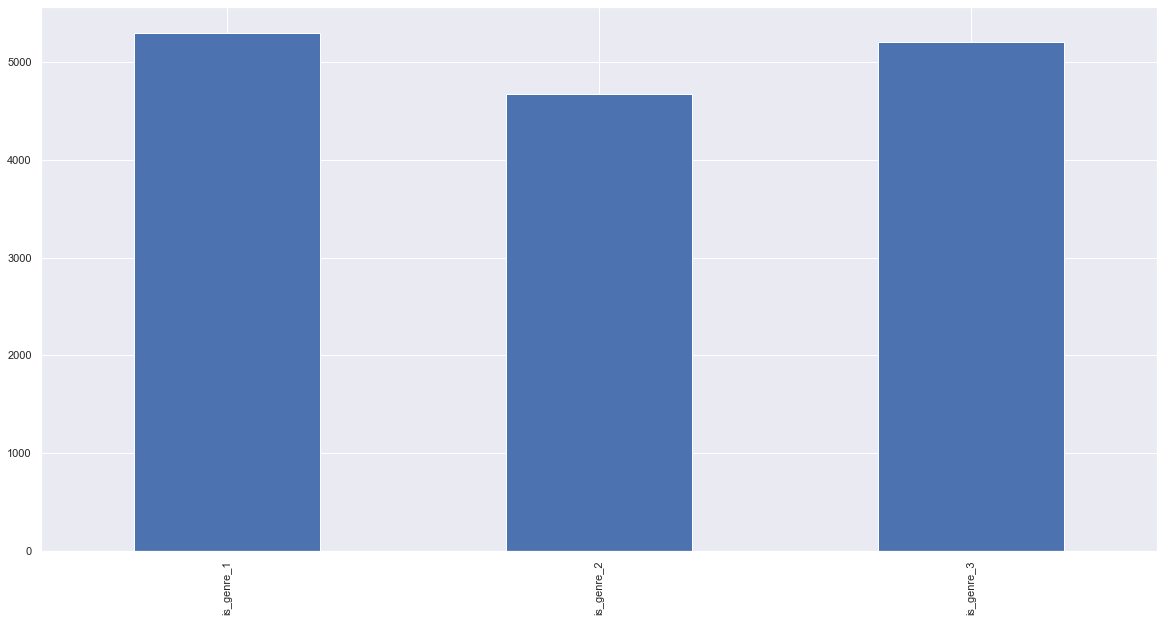

In [11]:
# Instructor Example

import numpy as np
import pandas as pd

df = pd.DataFrame()
df['x'] = np.random.normal(100, 10, 100)
df['is_genre_1'] = np.random.choice([0, 1], 100)
df['is_genre_2'] = np.random.choice([0, 1], 100)
df['is_genre_3'] = np.random.choice([0, 1], 100)

cols = ['is_genre_1', 'is_genre_2', 'is_genre_3']
output = []
for col in cols:
    sum_for_this_column = df[df[col] == 1].x.sum()
    output.append({col: sum_for_this_column})

pd.DataFrame(output).sum().plot.bar()

# Get Final DF

In [14]:
import Final.final_acquire as fa

import pre_processing_nick as pp

# Acquire & wrangle data
df = fa.wrangle_df()
df.head(2)

Using cached CSV


,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,runtime.1,imdb_id
id,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,False,3.49375,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,False,1995-12-09,1995,98.0,tt0113101
6,Judgment Night,False,3.88382,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,False,1993-10-15,1993,110.0,tt0107286


In [13]:
df.columns

Index(['title', 'success', 'success_rating', 'genres', 'cast_actor_1',
       'cast_actor_2', 'cast_actor_3', 'total_n_cast', 'budget', 'revenue',
       'profit_amount', 'vote_average', 'vote_count', 'production_companies',
       'production_countries', 'overview', 'popularity', 'runtime',
       'profitable', 'release_date', 'release_year', 'runtime.1', 'imdb_id'],
      dtype='object')

# Encode Data for Modeling 

In [17]:
model_df = pp.create_modeling_df()

TypeError: create_modeling_df() takes 0 positional arguments but 1 was given

# Feature Engineering

Which features are driving success?

### SelectKBest

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k = 8)

# find the top 8 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


ValueError: could not convert string to float: 'Beverly Hills Cop'

# Modeling

In [80]:
# Import modeling 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [83]:
train.head(2)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,runtime.1,imdb_id
id,,,,,,,,,,,,,,,,,,,,,,,
90,Beverly Hills Cop,True,71.708375,Action Comedy Crime,Eddie Murphy,Judge Reinhold,John Ashton,18.0,15000000.0,316360478.0,301360478.0,6.8,985.0,ParamountPictures EddieMurphyProductions,UnitedStatesofAmerica,Tough-talking Detroit cop Axel Foley heads to ...,8.503483,105.0,True,1984-11-29,1984,105.0,tt0086960
504,Monster,True,26.415630,Crime Drama,Charlize Theron,Christina Ricci,Bruce Dern,10.0,8000000.0,60378584.0,52378584.0,7.0,500.0,NewmarketFilms,UnitedStatesofAmerica,Aileen Wuornos is an emotionally scarred highw...,7.189024,110.0,True,2003-11-16,2003,110.0,tt0340855


In [95]:
train.columns

Index(['title', 'success', 'success_rating', 'genres', 'cast_actor_1',
       'cast_actor_2', 'cast_actor_3', 'total_n_cast', 'budget', 'revenue',
       'profit_amount', 'vote_average', 'vote_count', 'production_companies',
       'production_countries', 'overview', 'popularity', 'runtime',
       'profitable', 'release_date', 'release_year', 'runtime.1', 'imdb_id'],
      dtype='object')

In [96]:
# which gives the following best features.
sfs_features = ['budget', 'vote_average', 'vote_count', 'release_year',
                'is_genre_comedy', 'cast_actor_1_Robin Williams',
                'production_company_TwentiethCenturyFoxFilmCorporation',
                'production_company_other_company']    

In [6]:
# split into train, validate, test
train, validate, test = fa.train_validate_test_split(df)
train.shape, validate.shape, test.shape
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['success'])
y_train = train.success

X_validate = validate.drop(columns=['success'])
y_validate = validate.success

X_test = test.drop(columns=['success'])
y_test = test.success


In [89]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [91]:
# model.fit(X, y)

clf = clf.fit(X_train, y_train)

ValueError: could not convert string to float: 'Beverly Hills Cop'

Exploration phase identified arrays of possible divers for a movie success. In this section, we will create a machine learning algorithm model that better predicts movie success and use our findings as recommendations for our stakeholders. Three supervised machine learning classifications models were created in this project:  

- Logistic regression
- K-Nearest Neighbor (KNN)
- Decision tree

A baseline model for our project was created from engineered columns of success as a measure of overall performance of the models above. Our defination of a successful movie is guided by financial metrics a movie generates as captured by the dataset and 'perceived success' as expressed by features such as ratings, votes among othes. As is, the dataset baseline movie success accounts to 38.90%. 

The following sections will tabulate the models results over the train and validat subset and later test the best model over test subset to limit data leakage.

In [18]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

<table>
<thead>
    <tr>
        <th>Model</th>
        <th>Acuracy</th>
        <th>Precision</th>
        <th>Recall</th>
    </tr>
</thead>
<tbody>
<tr>
    <td>A</td><td>B</td><td>C</td>
</tr>
<tr>
    <td>X</td><td>Y</td><td>Z</td>
</tr>
</tbody>
</table>

### Test Model

## Conclusion & Recommendations